# COMP3134 BI & CRM Project – Group 6 Notebook

Source files:
- sales_6.csv
- customers_6.csv
- products_6.csv

In [1]:
import sys
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

print("Python:", sys.version)
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)

Python: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
Pandas: 2.2.2
NumPy: 1.26.4


In [2]:
# File Paths
DATA_DIR = Path('./data')
OUTPUT_DIR = Path('./output')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
IMAGE_OUTPUT_DIR = OUTPUT_DIR / 'image'
IMAGE_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR = OUTPUT_DIR / 'model'
MODEL_DIR.mkdir(parents=True, exist_ok=True)
CSV_DIR = OUTPUT_DIR / 'csv'
CSV_DIR.mkdir(parents=True, exist_ok=True)

sales_file = DATA_DIR / 'sales_6.csv'
customers_file = DATA_DIR / 'customers_6.csv'
products_file = DATA_DIR / 'products_6.csv'

## Data Process

### 數據概括

In [3]:
# Load raw data
sales_raw = pd.read_csv(sales_file)
customers = pd.read_csv(customers_file)
products = pd.read_csv(products_file)

# Load raw data
sales_raw = pd.read_csv(sales_file)
customers = pd.read_csv(customers_file)
products = pd.read_csv(products_file)

print('Sales shape:', sales_raw.shape)
print('Customers shape:', customers.shape)
print('Products shape:', products.shape)

# Quick preview
display(sales_raw.head())
display(customers.head())
display(products.head())

Sales shape: (4348, 5)
Customers shape: (1178, 4)
Products shape: (535, 3)


,Invoice no,Customer id,Product id list,Invoice date,Shopping mall
0,INV00001,C00712,P00442,25/12/2025,MK
1,INV00002,C00168,"P00270,P00442",16/05/2024,CYB
2,INV00003,C00904,"P00530,P00355,P00522,P00224",01/07/2024,ST
3,INV00004,C01112,P00157,31/03/2025,TKO
4,INV00005,C00361,"P00160,P00020,P00116,P00165",09/08/2024,ST


,Customer id,Gender,Age,Payment method
0,C00001,M,19,Credit Card
1,C00002,M,47,Cash
2,C00003,M,51,Cash
3,C00004,M,31,Cash
4,C00005,M,27,Cash


,Product id,Category,Price
0,P00001,Groceries,232.56
1,P00002,Electronics,5462.98
2,P00003,Groceries,166.36
3,P00004,Electronics,1561.48
4,P00005,Books,279.14


### 數據質量 （檢查是否有缺值）

In [4]:
# Basic data quality checks and type handling
print("Missing values (sales):")
print(sales_raw.isna().sum())
print("Missing values (customers):")
print(customers.isna().sum())
print("Missing values (products):")
print(products.isna().sum())

Missing values (sales):
Invoice no         0
Customer id        0
Product id list    0
Invoice date       0
Shopping mall      0
dtype: int64
Missing values (customers):
Customer id       0
Gender            0
Age               0
Payment method    0
dtype: int64
Missing values (products):
Product id    0
Category      0
Price         0
dtype: int64


### 數據ID Key格式驗證

In [5]:
# Format validation
invoice_format_ok = sales_raw['Invoice no'].str.match(r'^INV\d{5}$').all()
customer_format_ok = customers['Customer id'].str.match(r'^C\d{5}$').all()
product_format_ok = products['Product id'].str.match(r'^P\d{5}$').all()
print('Invoice format valid:', invoice_format_ok)
print('Customer format valid:', customer_format_ok)
print('Product format valid:', product_format_ok)

Invoice format valid: True
Customer format valid: True
Product format valid: True


### 數據日期範圍

In [6]:
# Date parsing
sales_raw['Invoice date'] = pd.to_datetime(sales_raw['Invoice date'], format='%d/%m/%Y', errors='coerce')
print('Earliest date:', sales_raw['Invoice date'].min(), 'Latest date:', sales_raw['Invoice date'].max())

Earliest date: 2024-01-01 00:00:00 Latest date: 2025-12-31 00:00:00


### 數據獨特值

In [7]:
# Unique values overview
print('Shopping mall unique values:', sales_raw['Shopping mall'].unique())
print('Gender unique values:', customers['Gender'].unique())
print('Payment method unique values:', customers['Payment method'].unique())

Shopping mall unique values: ['MK' 'CYB' 'ST' 'TKO']
Gender unique values: ['M' 'F']
Payment method unique values: ['Credit Card' 'Cash' 'Mobile Payment']


### 產品ID列表拆分

In [8]:
# Split multi-product column
sales_raw['Product id list'] = sales_raw['Product id list'].str.split(',')
exploded_sales = sales_raw.explode('Product id list')
# Rename 'Product id list' to 'Product id'
exploded_sales = exploded_sales.rename(columns={'Product id list': 'Product id'})
exploded_sales.head()

,Invoice no,Customer id,Product id,Invoice date,Shopping mall
0,INV00001,C00712,P00442,2025-12-25,MK
1,INV00002,C00168,P00270,2024-05-16,CYB
1,INV00002,C00168,P00442,2024-05-16,CYB
2,INV00003,C00904,P00530,2024-07-01,ST
2,INV00003,C00904,P00355,2024-07-01,ST


### 合并數據

In [9]:
# Merged Data
merged_products = pd.merge(exploded_sales, products, on='Product id', how='left')
merged_data = pd.merge(merged_products, customers, on='Customer id', how='left')
# Save and view
merged_data.to_csv(CSV_DIR / 'merged_data.csv', index=False, encoding='utf-8')
merged_data.head()

,Invoice no,Customer id,Product id,Invoice date,Shopping mall,Category,Price,Gender,Age,Payment method
0,INV00001,C00712,P00442,2025-12-25,MK,Toys,129.62,F,39,Cash
1,INV00002,C00168,P00270,2024-05-16,CYB,Electronics,1546.75,M,22,Credit Card
2,INV00002,C00168,P00442,2024-05-16,CYB,Toys,129.62,M,22,Credit Card
3,INV00003,C00904,P00530,2024-07-01,ST,Clothing,975.60,M,25,Cash
4,INV00003,C00904,P00355,2024-07-01,ST,Books,236.37,M,25,Cash


### 格式驗證

In [10]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13032 entries, 0 to 13031
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Invoice no      13032 non-null  object        
 1   Customer id     13032 non-null  object        
 2   Product id      13032 non-null  object        
 3   Invoice date    13032 non-null  datetime64[ns]
 4   Shopping mall   13032 non-null  object        
 5   Category        13032 non-null  object        
 6   Price           13032 non-null  float64       
 7   Gender          13032 non-null  object        
 8   Age             13032 non-null  int64         
 9   Payment method  13032 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 1018.3+ KB


## Exploratory Data Analysis (EDA)

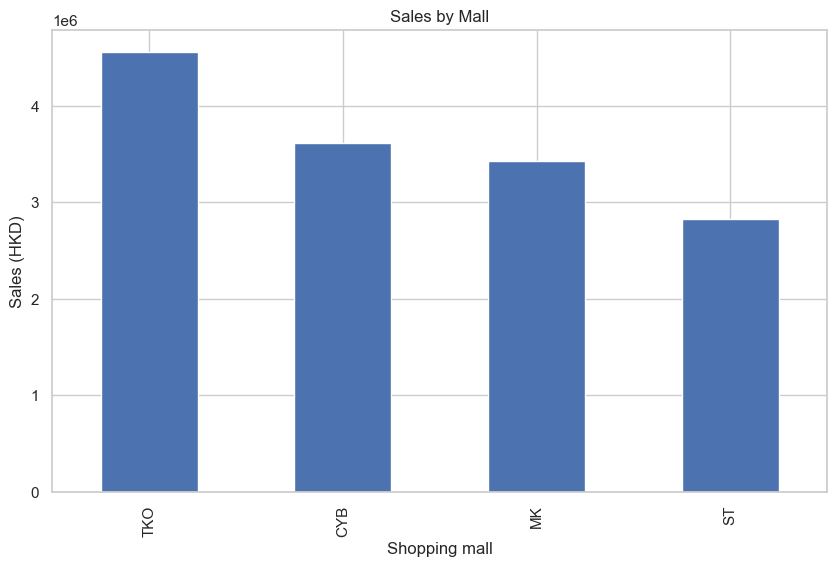

In [11]:
# Total sales / Sales by mall
mall_sales = merged_data.groupby('Shopping mall')['Price'].sum().sort_values(ascending=False)
mall_sales.plot(kind='bar', title='Sales by Mall')
plt.ylabel('Sales (HKD)')
plt.savefig(IMAGE_OUTPUT_DIR / 'sales_by_mall.png')
plt.show()

商場銷售表現呈現明顯差異，**TKO 商場以 480 萬 HKD 銷售額位居第一**，貢獻近三分之一總收入。**ST 商場僅 280 萬 HKD**，落後近 40%，可能是客流、品類或促銷不足。

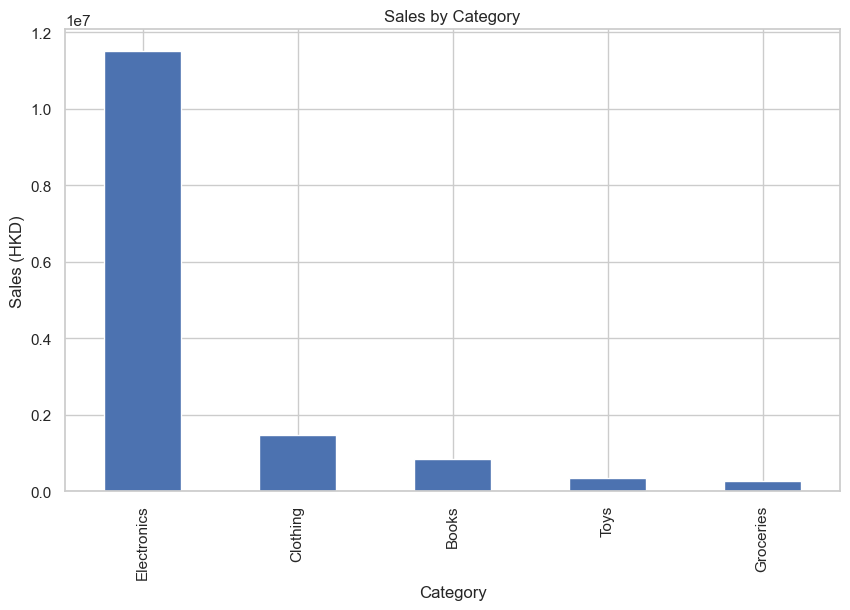

In [12]:
# Category revenue ranking
category_sales = merged_data.groupby('Category')['Price'].sum().sort_values(ascending=False)
category_sales.plot(kind='bar', title='Sales by Category')
plt.ylabel('Sales (HKD)')
plt.savefig(IMAGE_OUTPUT_DIR / 'sales_by_category.png')
plt.show()

從品類銷售可見，**電子產品貢獻 1,200 萬銷售額，佔比近 70%**，顯示客戶消費高度集中於高科技商品。

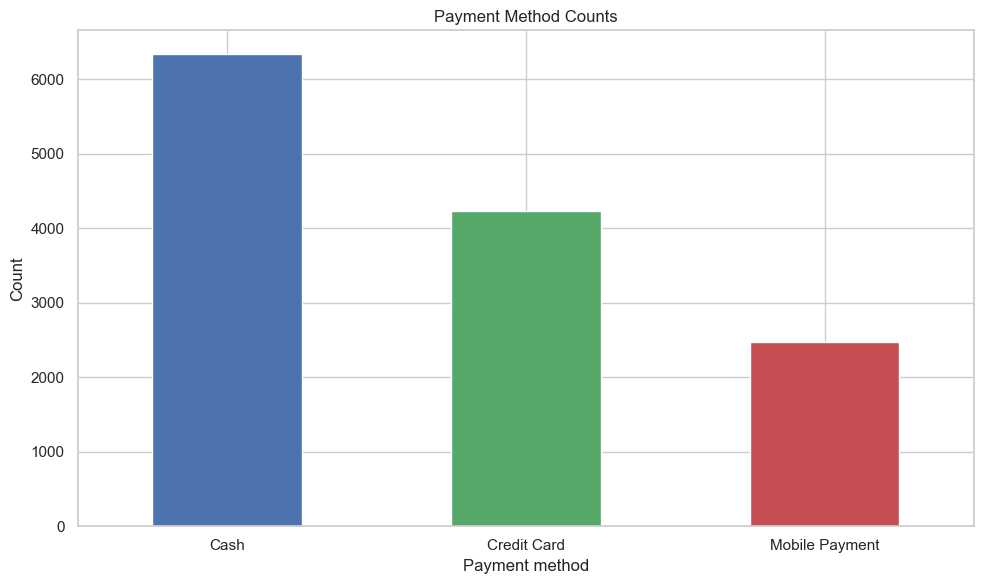

In [13]:
pay_counts = merged_data['Payment method'].value_counts(dropna=False).rename_axis('Payment method').reset_index(name='count')
pay_counts['pct'] = pay_counts['count'] / pay_counts['count'].sum()
ax = pay_counts.set_index('Payment method')['count'].plot(kind='bar', color=['#4C72B0','#55A868','#C44E52'])
plt.title('Payment Method Counts')
plt.ylabel('Count')
plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.savefig(IMAGE_OUTPUT_DIR / 'payment_method_counts.png')
plt.show()

Cash 最多（约 6.5k），其次 Credit Card（约 4.2k），Mobile Payment 最少（约 2.4k）。

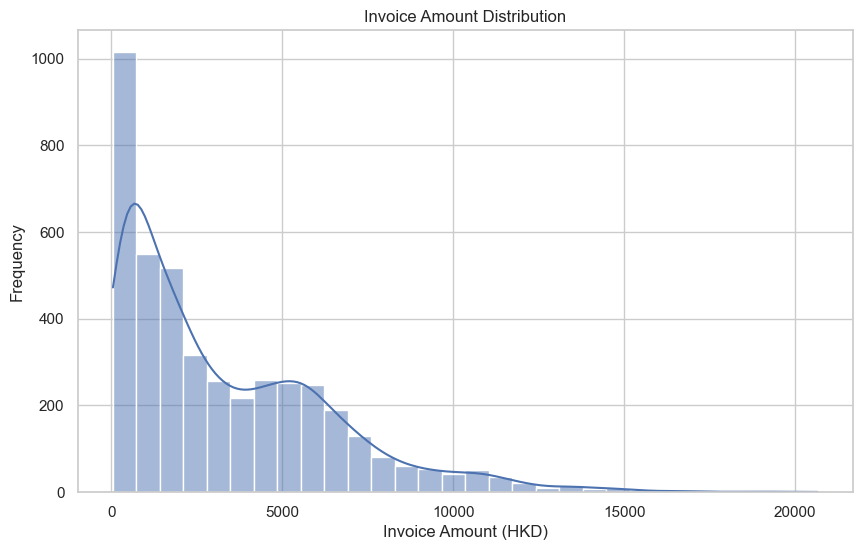

In [14]:
invoice_amounts = merged_data.groupby('Invoice no')['Price'].sum().reset_index(name='Invoice Amount')
sns.histplot(invoice_amounts['Invoice Amount'], bins=30, kde=True)
plt.title('Invoice Amount Distribution')
plt.xlabel('Invoice Amount (HKD)')
plt.ylabel('Frequency')
plt.savefig(IMAGE_OUTPUT_DIR / 'invoice_amount_distribution.png')
plt.show()

發票金額分佈呈現明顯右偏，峰值位於**500–1000 HKD**，顯示大部分客戶以小額消費為主。約**80% 發票金額低於 5000 HKD**，顯示日常消費集中在中低價位商品。
然而，存在少數**高於 10,000 HKD**的長尾發票，顯示潛在高價值客戶群。

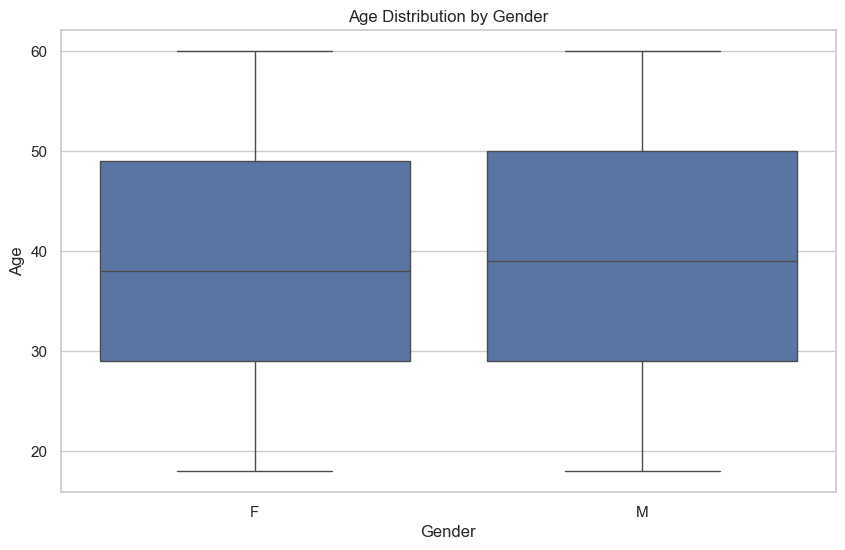

In [15]:
# Gender / Age distribution
sns.boxplot(data=merged_data.dropna(subset=['Age','Gender']), x='Gender', y='Age')
plt.title('Age Distribution by Gender')
plt.savefig(IMAGE_OUTPUT_DIR / 'age_distribution_by_gender.png')
plt.show()

男女客戶年齡分佈高度重疊，中位數皆為 40 歲，主力集中在 30–50 歲。

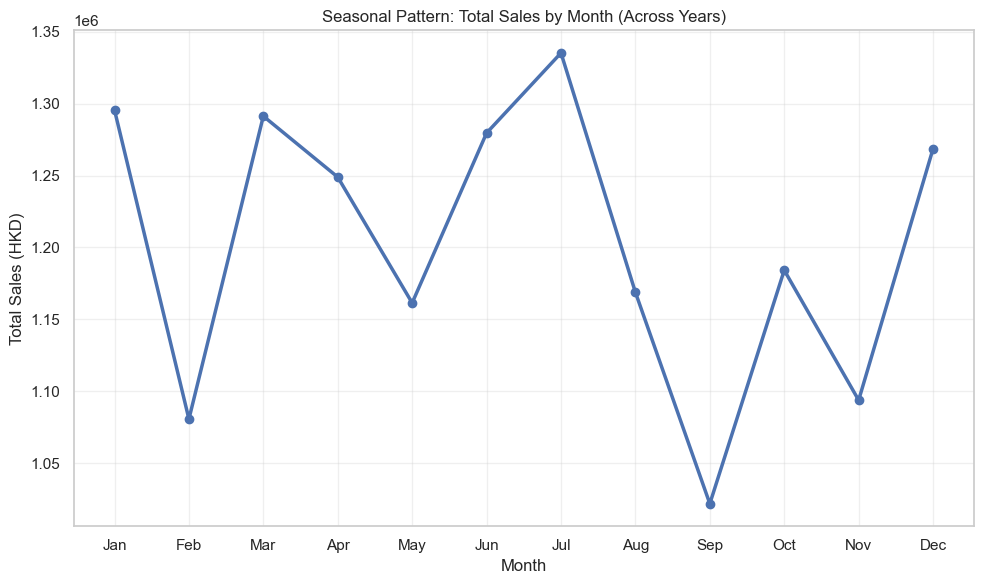

In [16]:
# Monthly trend & seasonality
merged_month = merged_data
merged_month['Year'] = merged_month['Invoice date'].dt.year
merged_month['Month'] = merged_month['Invoice date'].dt.month

seasonal_sales = merged_month.groupby('Month')['Price'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(seasonal_sales['Month'], seasonal_sales['Price'], marker='o', linewidth=2.5)
plt.title('Seasonal Pattern: Total Sales by Month (Across Years)')
plt.xlabel('Month')
plt.ylabel('Total Sales (HKD)')
plt.xticks(range(1, 13),
           ['Jan','Feb','Mar','Apr','May','Jun',
            'Jul','Aug','Sep','Oct','Nov','Dec'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(IMAGE_OUTPUT_DIR / 'seasonal_sales_pattern.png')
plt.show()

月銷售趨勢波動明顯，**7 月達全年最高 135 萬，9 月最低僅 100 萬**，無固定季節性。

## RFM

- R = Recency：距離最近一次購買的天數（越小越好）。
- F = Frequency：在觀察期內的交易次數或發票數（越大越好）。
- M = Monetary：在觀察期內的總消費金額（越大越好）。

In [17]:
df = merged_data

In [18]:
snapshot_date = df['Invoice date'].max() + pd.Timedelta(days=1)

rfm = df.groupby('Customer id').agg(
    Monetary=('Price', 'sum'),
    Frequency=('Invoice no', 'nunique'),
    LastPurchase=('Invoice date', 'max')
).reset_index()

rfm['Recency'] = (snapshot_date - rfm['LastPurchase']).dt.days
rfm = rfm.drop(columns=['LastPurchase'])

rfm['Monetary_log'] = np.log1p(rfm['Monetary'])

rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_score'] = pd.qcut(rfm['Monetary_log'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)

rfm['RFM_score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
rfm['RFM_numeric'] = rfm['R_score']*100 + rfm['F_score']*10 + rfm['M_score']

def segment_from_scores(row):
    if row['R_score'] >= 4 and row['F_score'] >= 4 and row['M_score'] >= 4:
        return 'Champions'
    if row['R_score'] >= 3 and row['F_score'] >= 3 and row['M_score'] >= 3:
        return 'Loyal'
    if row['R_score'] <= 2 and row['F_score'] >= 4:
        return 'Frequent but at risk'
    if row['R_score'] >= 4 and row['F_score'] <= 2:
        return 'New / Promising'
    if row['R_score'] <= 2 and row['F_score'] <= 2 and row['M_score'] <= 2:
        return 'At Risk / Churn'
    return 'Other'

rfm['segment'] = rfm.apply(segment_from_scores, axis=1)

rfm[['Customer id','Recency','Frequency','Monetary','R_score','F_score','M_score','RFM_score','segment']].head()

,Customer id,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,segment
0,C00001,59,3,11663.89,4,2,3,423,New / Promising
1,C00002,10,4,9110.17,5,3,3,533,Loyal
2,C00003,164,2,11245.63,3,1,3,313,Other
3,C00004,165,6,16331.02,3,5,4,354,Loyal
4,C00005,217,5,9873.15,2,4,3,243,Frequent but at risk


## Customer Segmentation (KMeans)

In [19]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [20]:
feat_cols = []
if 'Recency' in rfm.columns:
    feat_cols.append('Recency')
if 'Frequency' in rfm.columns:
    feat_cols.append('Frequency')
if 'Monetary_log' in rfm.columns:
    feat_cols.append('Monetary_log')
elif 'Monetary' in rfm.columns:
    rfm['Monetary_log'] = np.log1p(rfm['Monetary'])
    feat_cols.append('Monetary_log')

X = rfm[feat_cols].fillna(0).copy()

In [21]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [22]:
sil_scores = {}
for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled)
    sil = silhouette_score(X_scaled, km.labels_)
    sil_scores[k] = sil
best_k = max(sil_scores, key=sil_scores.get)
print('silhouette scores:', {k: round(v,3) for k,v in sil_scores.items()})
print('Select best_k =', best_k)

a:\CCW\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系統找不到指定的檔案。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "a:\CCW\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "a:\CCW\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "a:\CCW\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "a:\CCW\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^

silhouette scores: {2: 0.393, 3: 0.318, 4: 0.336, 5: 0.311, 6: 0.302, 7: 0.301, 8: 0.281}
Select best_k = 2


a:\CCW\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
a:\CCW\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


In [23]:
km = KMeans(n_clusters=best_k, random_state=42, n_init=20).fit(X_scaled)
rfm['cluster'] = km.labels_

a:\CCW\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


In [24]:
profile = rfm.groupby('cluster').agg(
    customers=('Customer id','count'),
    avg_recency=('Recency','mean'),
    avg_frequency=('Frequency','mean'),
    avg_monetary=('Monetary','mean'),
    median_monetary=('Monetary','median')
).reset_index().sort_values('customers', ascending=False)
profile.to_csv(CSV_DIR / 'cluster_profile.csv', index=False)
rfm.reset_index(drop=True).to_csv(CSV_DIR / 'customers_with_cluster.csv', index=False)
print('Saved cluster_profile.csv and customers_with_cluster.csv')

Saved cluster_profile.csv and customers_with_cluster.csv


In [25]:
try:
    merged_data
    merged_df = merged_data.copy()
    merged_df = merged_df.merge(rfm[['Customer id','cluster']], on='Customer id', how='left')
    cat_by_cluster = merged_df.groupby(['cluster','Category'])['Price'].sum().reset_index()
    top_cat = cat_by_cluster.sort_values(['cluster','Price'], ascending=[True,False]).groupby('cluster').head(3)
    top_cat.to_csv(CSV_DIR / 'cluster_top_categories.csv', index=False)
    print('Saved cluster_top_categories.csv')
except Exception:
    pass

Saved cluster_top_categories.csv


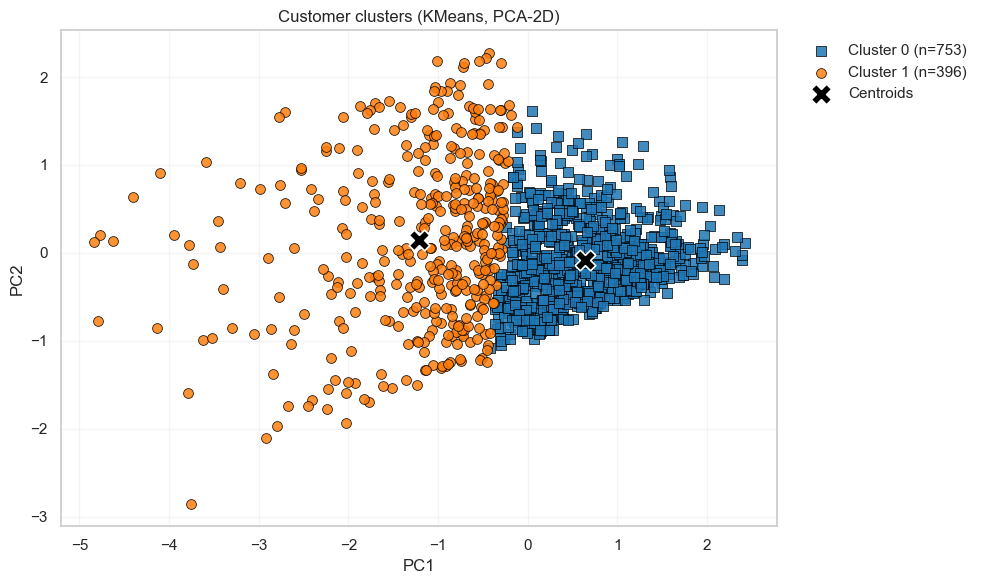

In [26]:
pca = PCA(n_components=2)
proj = pca.fit_transform(X_scaled)

centroids_pca = pca.transform(km.cluster_centers_)

clusters = sorted(rfm['cluster'].unique())
markers = ['s','o','v','^','P','X','D','*','<','>']
palette = sns.color_palette('tab10', n_colors=max(10, len(clusters)))

for i, cl in enumerate(clusters):
    mask = (rfm['cluster'] == cl).values
    col = palette[i % len(palette)]
    m = markers[i % len(markers)]
    plt.scatter(proj[mask, 0], proj[mask, 1],
                s=50, c=[col], marker=m, edgecolors='black', linewidths=0.6,
                alpha=0.85, label=f'Cluster {cl} (n={mask.sum()})')

plt.scatter(centroids_pca[:,0], centroids_pca[:,1],
            marker='X', s=220, c='black', edgecolors='white', linewidths=1.2, zorder=6, label='Centroids')

plt.title('Customer clusters (KMeans, PCA-2D)')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.grid(alpha=0.2)
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', frameon=False)
plt.tight_layout()
plt.savefig(IMAGE_OUTPUT_DIR / 'customer_clusters_pca.png')
plt.show()

兩群分布：
- Cluster 0（藍色方塊，n=753）：在 PC1 方向靠右且較集中，代表在被 PCA 捕捉的主要組合特徵上屬於「高值且行為一致」的一群（對應 R/F/M 高的群體）。
- Cluster 1（橙色圓點，n=396）：在 PC1 方向偏左且更分散，有長尾與離群點，代表群內異質性大（部分用戶明顯低值、部分接近邊界）。


中間有明顯重疊區（PC1 大約在 -0.5..+0.2 範圍），表示存在邊界客戶——這些人可能容易被營銷手段從一群推向另一群（適合做 A/B 測試）。


中心點（黑色 X）已投影到 PCA 空間，表示在原始 R/F/M（經標準化）空間的群心位置；可用來比較各群的「平均行為」。


分群品質：視覺上分離尚可但非完全分離（有重疊與離群），建議補充 silhouette_score 與群內方差檢查以量化分群穩定性。


業務含義（直接可落地）
- Cluster 0 → 優先做保留與交叉銷售（VIP 維護、look‑alike 拉新）。
- Cluster 1 → 做喚回/激活（限時券、個性化推薦），對長尾用戶做分層處理（有些可能只是偶發低價值、有些已真流失）。
- 邊界客群 → 設計小額誘因 vs 服務升級的 A/B，觀察哪類刺激更能把他們向 cluster0 推進。

In [27]:
from sklearn.metrics import silhouette_score
import joblib

In [28]:
sil = silhouette_score(X_scaled, km.labels_)
print('Silhouette score (km):', round(sil, 4))

Silhouette score (km): 0.3935


In [29]:
centroids_scaled = km.cluster_centers_
try:
    centroids_unscaled = scaler.inverse_transform(centroids_scaled)
    centroids_df = pd.DataFrame(centroids_unscaled, columns=feat_cols).reset_index().rename(columns={'index':'cluster'})
except Exception:
    centroids_df = pd.DataFrame(centroids_scaled, columns=feat_cols).reset_index().rename(columns={'index':'cluster'})

print('Centroids (feature-space):')
display(centroids_df)

Centroids (feature-space):


,cluster,Recency,Frequency,Monetary_log
0,0,112.095491,4.602122,9.590146
1,1,304.767089,2.222785,8.156604


In [30]:
cluster_summary = rfm.groupby('cluster').agg(
    customers=('Customer id','count'),
    mean_recency=('Recency','mean'),
    mean_frequency=('Frequency','mean'),
    mean_monetary=('Monetary','mean'),
    median_monetary=('Monetary','median')
).reset_index().sort_values('customers', ascending=False)
print('Cluster summary:')
display(cluster_summary)

Cluster summary:


,cluster,customers,mean_recency,mean_frequency,mean_monetary,median_monetary
0,0,753,111.649402,4.602922,16464.067463,14719.15
1,1,396,305.128788,2.227273,5132.999268,4550.20


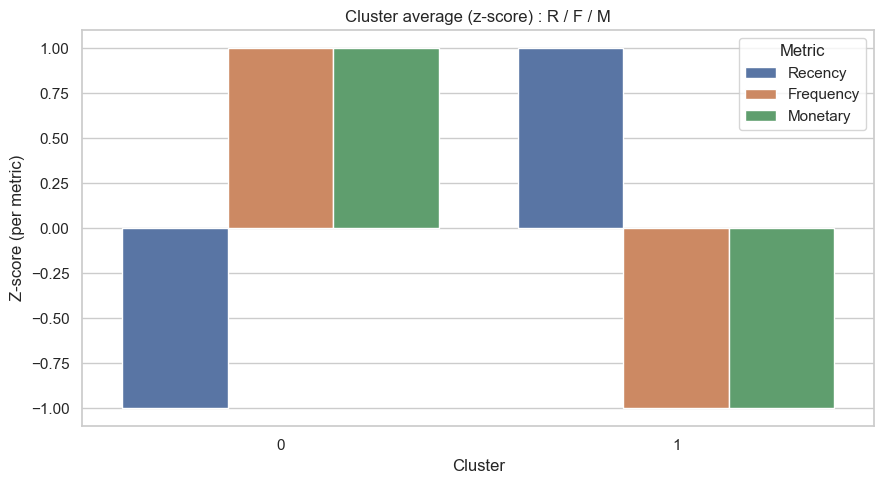

In [31]:
cluster_means = rfm.groupby('cluster')[['Recency','Frequency','Monetary']].mean().reset_index()

cluster_means_norm = cluster_means.copy()
cluster_means_norm[['Recency','Frequency','Monetary']] = cluster_means_norm[['Recency','Frequency','Monetary']].apply(
    lambda x: (x - x.mean()) / (x.std(ddof=0) + 1e-9)
)
cluster_means_melt = cluster_means_norm.melt(id_vars='cluster', var_name='metric', value_name='z_value')

plt.figure(figsize=(9,5))
sns.barplot(data=cluster_means_melt, x='cluster', y='z_value', hue='metric')
plt.title('Cluster average (z-score) : R / F / M')
plt.xlabel('Cluster'); plt.ylabel('Z-score (per metric)')
plt.legend(title='Metric'); plt.tight_layout()
plt.savefig(IMAGE_OUTPUT_DIR / 'cluster_rfm_means_zscore.png')
plt.show()
plt.close()

In [32]:
dists = np.linalg.norm(proj[:, None, :] - centroids_pca[None, :, :], axis=2)  
sorted_idx = np.argsort(dists, axis=1)
d1 = np.take_along_axis(dists, sorted_idx[:, :1], axis=1).ravel()
d2 = np.take_along_axis(dists, sorted_idx[:, 1:2], axis=1).ravel()
delta = d2 - d1

th = np.percentile(delta, 25)
boundary_mask = delta <= th
boundary_df = pd.DataFrame({
    'Customer id': rfm['Customer id'].values,
    'cluster': rfm['cluster'].values,
    'PC1': proj[:,0],
    'PC2': proj[:,1],
    'dist_to_best': d1,
    'dist_to_second': d2,
    'delta': delta
})
boundary_candidates = boundary_df[boundary_mask].sort_values('delta')
boundary_candidates.to_csv(CSV_DIR / 'boundary_customers.csv', index=False)
print(f'Saved {len(boundary_candidates)} boundary candidates to output/boundary_customers.csv (threshold delta<= {th:.4f})')

Saved 288 boundary candidates to output/boundary_customers.csv (threshold delta<= 0.6406)


In [33]:
joblib.dump(km, MODEL_DIR / 'kmeans_model.joblib')
joblib.dump(scaler, MODEL_DIR / 'scaler.joblib')
joblib.dump(pca, MODEL_DIR / 'pca.joblib')
print('Saved kmeans/scaler/pca under output/model/')

Saved kmeans/scaler/pca under output/model/


## Persona & High Value Customer

In [34]:
# Observation period in years
obs_days = (snapshot_date - df['Invoice date'].min()).days
obs_years = max(obs_days / 365.0, 1/365.0)

# Annualized spend
rfm['Annualized_spend'] = rfm['Monetary'] / obs_years

# Enrich RFM with customer demographics
try:
    rfm_enriched = rfm.merge(customers, on='Customer id', how='left')
except Exception:
    rfm_enriched = rfm.copy()

# Build personas table
personas = rfm_enriched.groupby('cluster').agg(
    customers=('Customer id','count'),
    avg_recency=('Recency','mean'),
    avg_frequency=('Frequency','mean'),
    avg_monetary=('Monetary','mean'),
    annualized_spend=('Annualized_spend','mean')
).reset_index()

# Define persona labels based on cluster characteristics
def label_persona(row):
    if row['avg_monetary'] >= personas['avg_monetary'].quantile(0.75):
        return 'High-Value (VIP)'
    if row['avg_frequency'] >= personas['avg_frequency'].quantile(0.75):
        return 'Frequent Buyer'
    if row['avg_recency'] >= personas['avg_recency'].quantile(0.75):
        return 'Dormant / At-risk'
    return 'Mid-Value'
personas['persona_label'] = personas.apply(label_persona, axis=1)

# Define marketing tactics per persona
personas['acquisition_tactic'] = personas['persona_label'].map({
    'High-Value (VIP)': 'Referral / look-alike ads',
    'Frequent Buyer': 'Bundle upsell discounts',
    'Dormant / At-risk': 'Win-back coupons',
    'Mid-Value': 'Welcome bundle / cross-sell'
})
personas['retention_tactic'] = personas['persona_label'].map({
    'High-Value (VIP)': 'Exclusive early access + premium service',
    'Frequent Buyer': 'Loyalty points per purchase',
    'Dormant / At-risk': 'Timelimited discount + personalized recs',
    'Mid-Value': 'Targeted product recommendations'
})

# Export personas and enriched customer data
personas.to_csv(CSV_DIR / 'personas_table.csv', index=False)
rfm_enriched.to_csv(CSV_DIR / 'customers_with_cluster_enriched.csv', index=False)

# Export high-value customers
top_cluster = personas.loc[personas['avg_monetary'].idxmax(), 'cluster']
high_value_customers = rfm_enriched[rfm_enriched['cluster'] == top_cluster]
high_value_customers.to_csv(CSV_DIR / 'high_value_customers.csv', index=False)

In [35]:
rfm_persona = rfm_enriched.merge(personas[['cluster','persona_label']], on='cluster', how='left')

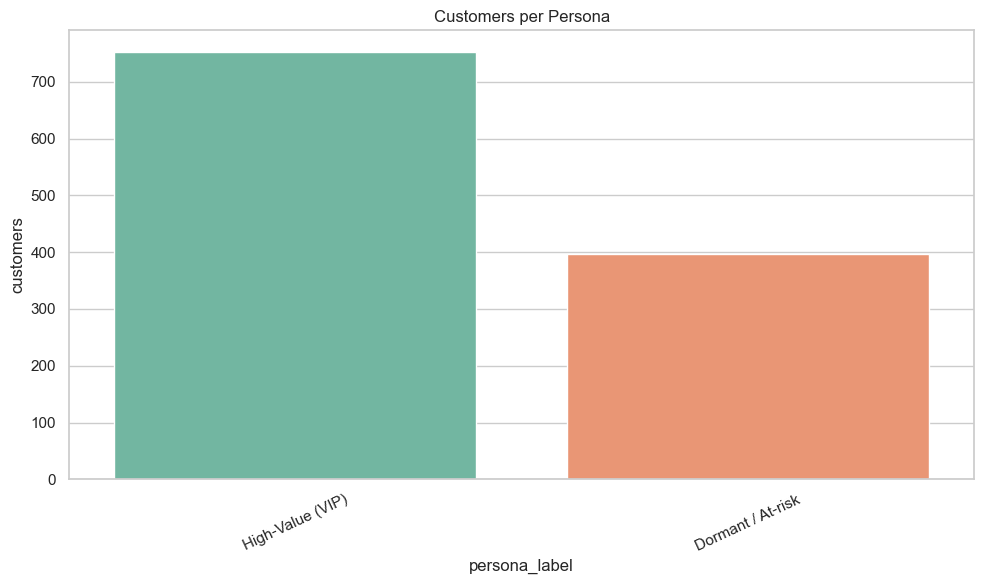

In [36]:
order = personas.sort_values('customers', ascending=False)['persona_label']
sns.barplot(data=personas, x='persona_label', y='customers', order=order, hue='persona_label', palette='Set2', legend=False)
plt.xticks(rotation=25)
plt.title('Customers per Persona')
plt.tight_layout()
plt.savefig(IMAGE_OUTPUT_DIR / 'personas_counts.png')
plt.show()
plt.close()

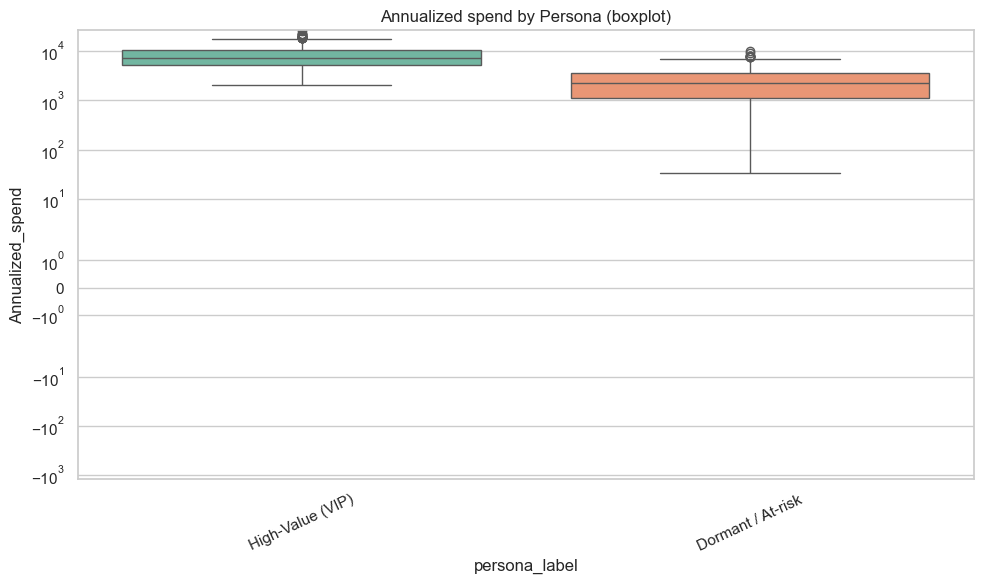

In [37]:
sns.boxplot(data=rfm_persona.dropna(subset=['Annualized_spend','persona_label']),
            x='persona_label', y='Annualized_spend', hue='persona_label', palette='Set2', legend=False)
plt.yscale('symlog')
plt.xticks(rotation=25)
plt.title('Annualized spend by Persona (boxplot)')
plt.tight_layout()
plt.savefig(IMAGE_OUTPUT_DIR / 'persona_annualized_spend_box.png')
plt.show()
plt.close()

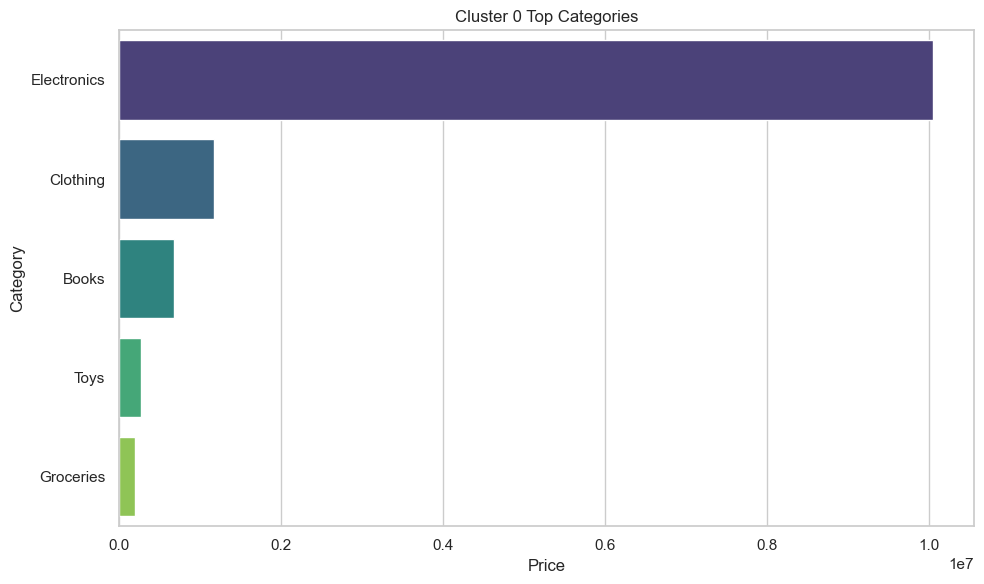

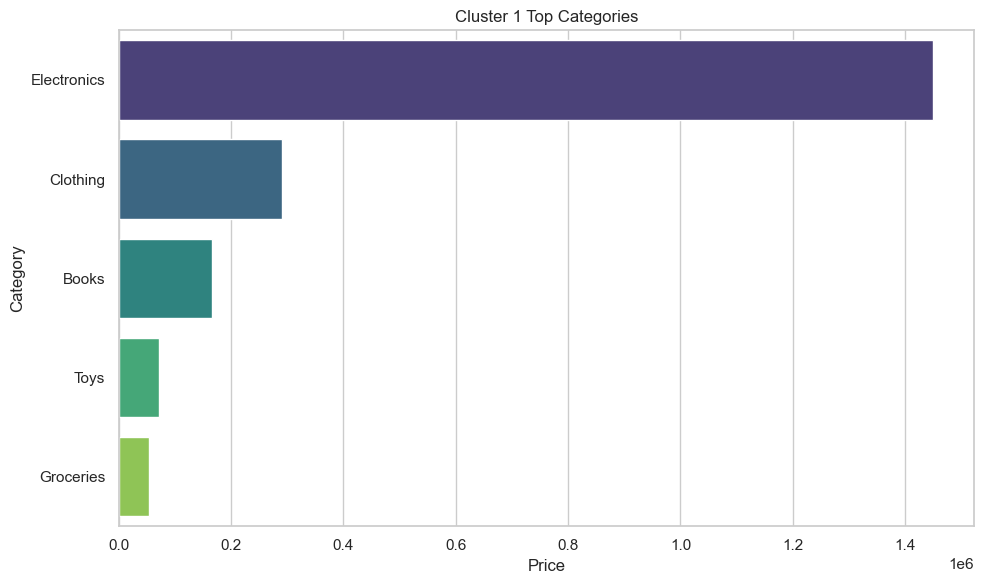

Saved top categories csv and images.


In [38]:
merged_for_ar = merged_data.merge(rfm[['Customer id','cluster']], on='Customer id', how='left')
cat_by_persona = merged_for_ar.groupby(['cluster','Category'])['Price'].sum().reset_index()
top_cat = cat_by_persona.sort_values(['cluster','Price'], ascending=[True,False]).groupby('cluster').head(5)
top_cat.to_csv(CSV_DIR / 'top_categories_per_persona.csv', index=False)

for cl in sorted(top_cat['cluster'].unique()):
    dfc = top_cat[top_cat['cluster']==cl]
    sns.barplot(data=dfc, x='Price', y='Category', hue='Category', palette='viridis', legend=False)
    plt.title(f'Cluster {cl} Top Categories')
    plt.tight_layout()
    plt.savefig(IMAGE_OUTPUT_DIR / f'cluster_{cl}_top_categories.png')
    plt.show()
    plt.close()
print('Saved top categories csv and images.')

## Association Rule Mining

從發票資料做購物籃關聯規則
- support（支持度） = 同时出现 antecedent+consequent 的交易占比（说明规则覆盖多少交易）。
- confidence（置信度） = 在包含 antecedent 的交易中也包含 consequent 的比例（P(A→B) ≈ P(B|A)）。
- lift（提升度） = confidence / 支持度( B )，>1 表示正相关，越大表示关联越强（排除基线频率影响）。

In [39]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [40]:
tx = df.groupby('Invoice no')['Product id'].apply(list).tolist()

te = TransactionEncoder()
te_ary = te.fit(tx).transform(tx)
df_onehot = pd.DataFrame(te_ary, columns=te.columns_)

In [41]:
freq_items = apriori(df_onehot, min_support=0.01, use_colnames=True)

In [42]:
rules = association_rules(freq_items, metric="confidence", min_threshold=0.3)

In [43]:
rules = rules[(rules['lift'] > 1.2)].sort_values(['lift','confidence'], ascending=False)

In [44]:
display(rules[['antecedents','consequents','support','confidence','lift']].head())
rules.to_csv(CSV_DIR / 'association_rules.csv', index=False)

,antecedents,consequents,support,confidence,lift
1,(P00442),(P00270),0.089236,0.960396,10.160102
0,(P00270),(P00442),0.089236,0.944039,10.160102
2,(P00387),(P00271),0.093836,0.978417,9.824846
3,(P00271),(P00387),0.093836,0.942263,9.824846
